In [2]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.animation import FuncAnimation
%pip install scikit-opt
from sko.PSO import PSO
import numpy as np
from scipy.fft import dct, idct

Note: you may need to restart the kernel to use updated packages.


# Rosenbrock function

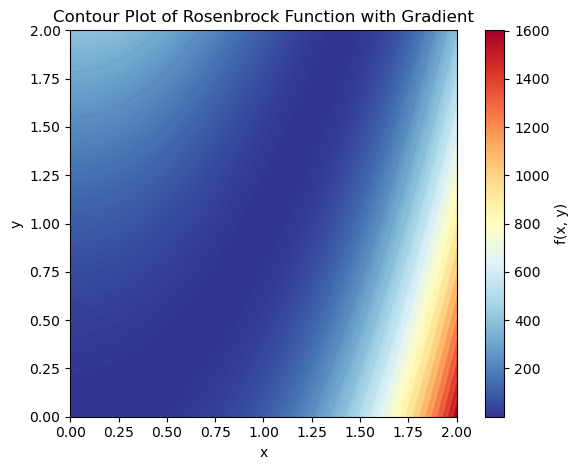

In [23]:
Lx, Ly = 2, 2  # 区域大小
# 生成数据网格
x = np.linspace(0, Lx, 1000) 
y = np.linspace(0, Ly, 1000) 
X, Y = np.meshgrid(x, y)

# 计算函数值 (Rosenbrock 函数)
Z = (1 - X)**2 + 100 * (Y - X**2)**2

# 使用 imshow 创建颜色渐变图
plt.imshow(Z, cmap='RdYlBu_r', extent=[0, 2, 0, 2], interpolation='bilinear', aspect='equal', origin='lower')
plt.colorbar(label='f(x, y)')
plt.contour(X, Y, Z, levels=20, cmap='RdYlBu_r', alpha=1)
# 设置轴标签
plt.xlabel('x')
plt.ylabel('y')
plt.title('Contour Plot of Rosenbrock Function with Gradient')

# 移除坐标轴边框
plt.gca().set_facecolor('black')
plt.tight_layout()

# 显示图形
plt.show()

# 论文方法取样 9x9

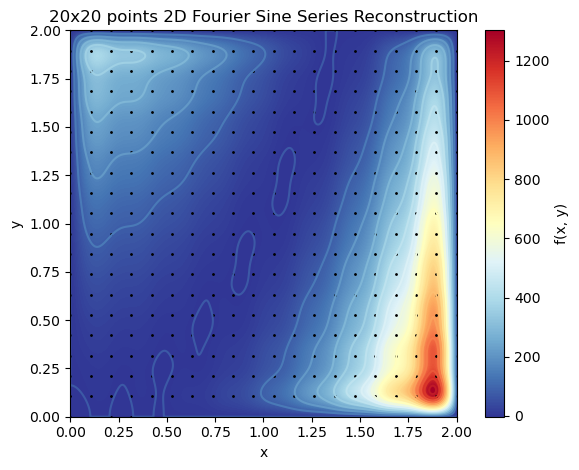

In [25]:
# 生成 9x9 离散点
nx, ny = 20, 20
Lx, Ly = 2, 2  # 定义网格的范围
x_points = np.linspace(0, Lx, nx)
y_points = np.linspace(0, Ly, ny)
X_grid, Y_grid = np.meshgrid(x_points, y_points)

# 计算函数值 (Rosenbrock 函数)
Z_original = (1 - X_grid)**2 + 100 * (Y_grid - X_grid**2)**2

# 计算 2D Fourier sine series coefficients
def compute_2d_fourier_sine_coeffs(Z, nx, ny, Lx, Ly):
    M, N = nx - 1, ny - 1  # Maximum indices for m, n (up to 8)
    b_mn = np.zeros((M, N))
    
    for m in range(1, M + 1):
        for n in range(1, N + 1):
            integrand = Z * np.sin(m * np.pi * X_grid / Lx) * np.sin(n * np.pi * Y_grid / Ly)
            b_mn[m-1, n-1] = (4 / (M * N)) * np.sum(integrand)
    return b_mn

# 计算系数
b_mn = compute_2d_fourier_sine_coeffs(Z_original, nx, ny, Lx, Ly)

# 重构 2D Fourier sine series at the 9x9 points
Z_fourier = np.zeros((len(X), len(Y)))
for m in range(1, nx):
    for n in range(1, ny):
        Z_fourier += b_mn[m-1, n-1] * np.sin(m * np.pi * X / Lx) * np.sin(n * np.pi * Y / Ly)

# 使用 imshow 创建颜色渐变图
plt.imshow(Z_fourier, cmap='RdYlBu_r', extent=[0, 2, 0, 2], interpolation='bilinear', aspect='equal', origin='lower')
plt.colorbar(label='f(x, y)')
# 设置轴标签
plt.xlabel('x')
plt.ylabel('y')
plt.title(f'{nx}x{ny} points 2D Fourier Sine Series Reconstruction')
plt.scatter(X_grid, Y_grid, c='black', s=1, label='Original 10x10 Points')
# 移除坐标轴边框
plt.gca().set_facecolor('black')
plt.tight_layout()
plt.contour(X, Y, Z_fourier, levels=20, cmap='RdYlBu_r', alpha=1)
# 显示图形
plt.show()


# scipy.fft.dct 计算 并给初始a0加权1/2

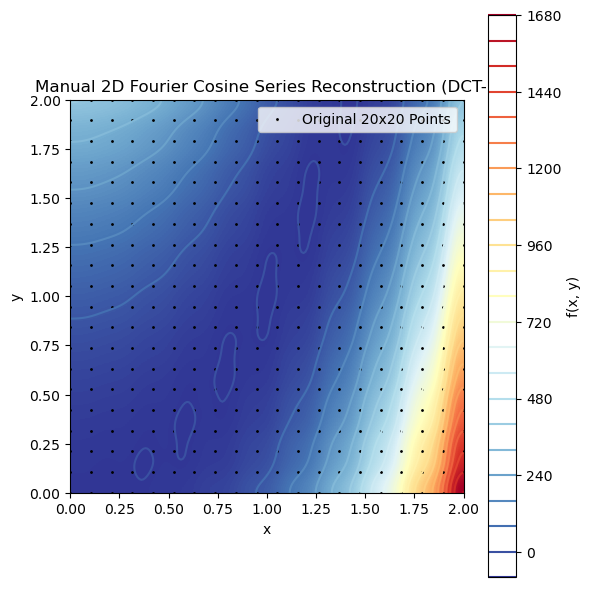

In [29]:
# 设置参数
Nx, Ny = 20, 20  # DCT-I 系数的网格大小

# 1. 创建 2D 网格 & 随机函数值
x = np.linspace(0, Lx, Nx)
y = np.linspace(0, Ly, Ny)
X, Y = np.meshgrid(x, y)

Z = (1 - X)**2 + 100 * (Y - X**2)**2  # 注意 shape 为 (Ny, Nx)

# 2. 归一化 x 和 y 坐标（用于高分辨率计算）
x_min, x_max = x.min(), x.max()
y_min, y_max = y.min(), y.max()

# 3. 执行 DCT-I（先按 y 方向，再按 x）
Z_dct = dct(dct(Z.T, type=1, norm=None).T, type=1, norm=None)

# 4. 手动高分辨率重建函数
def dct2_reconstruct(xh, yh, a, Nx, Ny):
    """
    使用 DCT-I 系数手动重建 f(x, y)，xh 和 yh 是归一化 [0, 1] 的高分辨率网格。
    a 是 DCT-I 系数，形状为 (Ny, Nx)
    """
    Z_rec = np.zeros_like(xh)
    for m in range(Nx):
        for n in range(Ny):
            coef = a[n, m]  # 注意索引顺序与 numpy shape 对应
            if m == 0 or m == Nx - 1:
                coef /= 2
            if n == 0 or n == Ny - 1:
                coef /= 2
            Z_rec += coef * np.cos(m * np.pi * xh) * np.cos(n * np.pi * yh)
    Z_rec /= (Nx - 1) * (Ny - 1)
    return Z_rec

# 5. 高分辨率网格
x_hr = np.linspace(0, Lx, 200)
y_hr = np.linspace(0, Ly, 200)
X_hr, Y_hr = np.meshgrid(x_hr, y_hr)

# 归一化高分辨率坐标
Xn_hr = (X_hr - x_min) / (x_max - x_min)
Yn_hr = (Y_hr - y_min) / (y_max - y_min)

# 重建高分辨率图像
Z_hr = dct2_reconstruct(Xn_hr, Yn_hr, Z_dct, Nx, Ny)

# 6. 可视化
plt.figure(figsize=(6, 6))
plt.imshow(Z_hr, extent=[0, Lx, 0, Ly], origin='lower',
           cmap='RdYlBu_r', aspect='equal')
plt.contour(X_hr, Y_hr, Z_hr, levels=20, cmap='RdYlBu_r', alpha=1)
plt.colorbar(label='f(x, y)')
plt.scatter(X, Y, c='black', s=1, label=f'Original {Nx}x{Nx} Points')
plt.title('Manual 2D Fourier Cosine Series Reconstruction (DCT-I)')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.tight_layout()
plt.show()


# PSO


In [56]:
# 设置迭代次数
max_iter = 50


# 定义 Rosenbrock 目标函数
def rosenbrock_objective(pos):
    x, y = pos  # PSO provides [x, y]
    Xn_hr = (x - x_min) / (x_max - x_min)  # 归一化到 [0, 1]
    Yn_hr = (y - y_min) / (y_max - y_min)  # 归一化到 [0, 1]
    Z_hr = dct2_reconstruct(Xn_hr, Yn_hr, Z_dct, Nx, Ny)
    return Z_hr  # PSO minimizes this value

# 初始化 PSO
pso = PSO(func=rosenbrock_objective, n_dim=2, pop=20, max_iter=max_iter,
          lb=[0, 0], ub=[2, 2],w=0.5, c1=1, c2=1.1,)

pso.record_mode = True
pso.run()



(array([1.0440813, 1.1121268]), array([-0.50740804]))

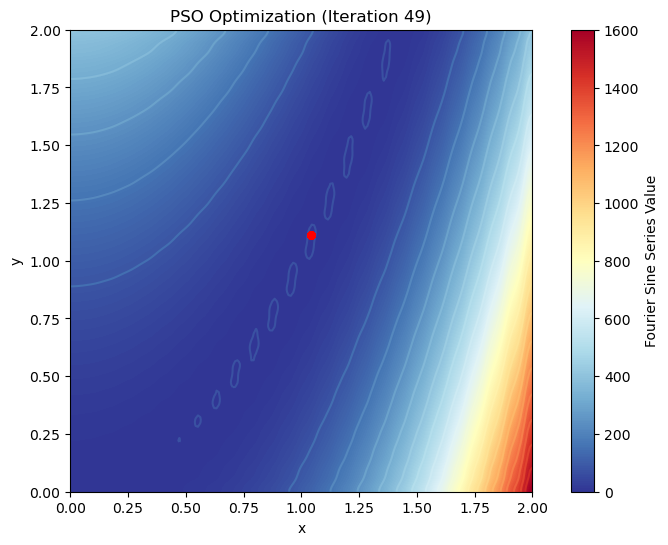

In [57]:
# Set up the figure and axis
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_title('PSO Optimization on Rosenbrock Function over Fourier Background', loc='center')

# 使用 imshow 创建颜色渐变图 as the background
im = ax.imshow(Z_hr, cmap='RdYlBu_r', extent=[0, 2, 0, 2], interpolation='bilinear', aspect='equal', origin='lower')
plt.colorbar(im, ax=ax, label='Fourier Sine Series Value')
plt.contour(X_hr, Y_hr, Z_hr, levels=20, cmap='RdYlBu_r', alpha=1)
# 设置轴标签
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('PSO Optimization over 2D Fourier Sine Series')

# 移除坐标轴边框
ax.set_facecolor('black')

# Initialize scatter plot for particles
line, = ax.plot([], [], 'r.', markersize=10, label='PSO Particles')

# Set axis limits (match imshow extent)
ax.set_xlim(0, 2)
ax.set_ylim(0, 2)
# Enable interactive mode
plt.ion()

# Animation update function
def update_scatter(frame):
    i, j = frame // 10, frame % 10
    ax.set_title(f'PSO Optimization (Iteration {i})')
    
    X_list = pso.record_value['X']
    V_list = pso.record_value['V']
    # Get particle positions for iteration i, interpolated
    X_tmp = X_list[i] + V_list[i] * j / 10.0  # Interpolate using velocity
    X_tmp = X_tmp.reshape(-1, 2)  # Reshape to (pop, 2) for x, y pairs
    
    # Update scatter plot with 2D positions
    plt.setp(line, 'xdata', X_tmp[:, 0], 'ydata', X_tmp[:, 1])
    
    return line,

# Create animation
ani = FuncAnimation(fig, update_scatter, blit=True, interval=25, frames=max_iter * 10)

# Save animation as GIF
ani.save('pso_rosenbrock_fourier_background_N=9x9.gif', writer='pillow')

# Show plot
plt.show()
